In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import pickle
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import easydict

In [2]:
sujets = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
times = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

In [3]:
with open('data/enregistrement_%s_%s.pkl'%(sujets[0], times[0]), 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
datafile = 'data/enregistrement_%s_%s.asc'%(sujets[0], times[0])

In [4]:
def moulti_fit(sujet, trial, nb_fit=50, perturbation=200):
    with open('data/enregistrement_%s_%s.pkl'%(sujets[sujet], times[sujet]), 'rb') as fichier :
        exp = pickle.load(fichier, encoding='latin1')
    datafile = 'data/enregistrement_%s_%s.asc'%(sujets[sujet], times[sujet])

    A = ANEMO(exp) 
    Fit = ANEMO.Fit(exp)
    Plot = ANEMO.Plot(exp)

    #= 1 ===============================================================================================
    data_full = read_edf(datafile, 'TRIALID')

    Plot.plot_fit(data_full, trials=trial, fig_width=30)

    arg = A.arg(data_full[trial], trial=trial, block=0)
    velocity = A.velocity_NAN(**arg)
    old_latency, old_steady_state, old_anti = A.classical_method.Full(velocity, arg.TargetOn-arg.t_0)
    rere = Fit.Fit_trial(velocity, value_latency=old_latency, value_steady_state=old_steady_state, value_anti=old_anti, **arg)
    
    result_full_data = rere.values
    for k in ['latency', 'start_anti'] :
        result_full_data[k] = result_full_data[k] - (arg.TargetOn-arg.t_0)
    #print('result_full_data =', result_full_data)

    #= 2 ===============================================================================================
    color = 'g'
    result_red_data = []
    
    step = 2
    i=0
    
    data_red = read_edf(datafile, 'TRIALID')
    for var in data_red[trial].keys() :
        if var != 'events' :
            data_red[t][var] = np.array([data_red[trial][var][x] for x in range(i, len(data_red[trial][var]), step)])        
    arg_red = A.arg(data_red[trial], trial=trial, block=0)
    
    #-------------------------------------------------------------------------------
    max_latency = len(arg.trackertime[:-int(280/step)])

    
    a = easydict.EasyDict()
    for v in ['StimulusOn', 'StimulusOf', 'TargetOn', 'TargetOff','t_0']:
        a[v] = int(arg_red[v]/step)

    veve = [velocity[t] for t in np.arange(i, len(velocity), step)]
    value_latency = A.classical_method.latency(veve)
    value_anti = np.nanmean(veve[(a.TargetOn-a.t_0)-int(50/step):(a.TargetOn-a.t_0)+int(50/step)])
    value_steady_state = abs(np.nanmean(veve[(a.TargetOn-a.t_0)+int(400/step):(a.TargetOn-a.t_0)+int(600/step)]))

    if value_latency >= max_latency-(50/step) : value_latency = max_latency-(150/step)
    if value_latency > (250/step) :             value_latency = a.TargetOn-a.t_0+(100/step)
    if np.isnan(value_latency) :                value_latency = a.TargetOn-a.t_0+(100/step)
    

    #-------------------------------------------------------------------------------
    np.random.seed(10)
    list_latency = value_latency + perturbation*np.random.rand(nb_fit)*np.random.choice([-1,1], nb_fit)
    print(list_latency)
    
    
    #-------------------------------------------------------------------------------
    for lat in list_latency :

        param_fit=[{'name':'steady_state', 'value':value_steady_state, 'min':5., 'max':40., 'vary':True},
                   {'name':'dir_target',   'value':arg_red.dir_target, 'min':None, 'max':None, 'vary':False},
                   {'name':'a_anti',       'value':lat*step, 'min':-40.*step, 'max':40.*step, 'vary':True},
                   {'name':'latency',      'value':value_latency,
                      'min':a.TargetOn-a.t_0+(75/step), 'max':max_latency, 'vary':True},
                   {'name':'start_anti',   'value':a.TargetOn-a.t_0-(100/step),
                      'min':a.StimulusOf-a.t_0-(200/step), 'max':a.TargetOn-a.t_0+(75/step), 'vary':'vary'},
                   {'name':'tau',  'value':15., 'min':13., 'max':80., 'vary':'vary'}]

        inde_vars={'x':np.arange(len(arg_red.trackertime[:-int(280/step)]))}

        #===================================================================
        rere = Fit.Fit_trial(veve, param_fit=param_fit, inde_vars=inde_vars, time_sup=int(280/step))
        result_red = rere.values
        result_red['a_anti'] = result_red['a_anti']/step
        for k in ['latency', 'start_anti'] :
            result_red[k] = result_red[k]*step
        
        fit = A.Equation.fct_velocity(arg.trackertime[:-280]-arg.t_0, **result_red)
        plt.plot(arg.trackertime[:-280]-arg.TargetOn, fit, c=color)

        for k in ['latency', 'start_anti'] : result_red[k] = result_red[k] - (arg.TargetOn-arg.t_0)
        result_red_data.append(result_red)

    return(result_full_data, result_red_data)

In [5]:
def histoto(result_full_data_, result_red_data_, name, color, bins=50):
    
    
    x_range = {'steady_state': [ 5,  40], 'a_anti':     [ -40, 40],
               'latency':      [75, 500], 'start_anti': [-500, 75],
               'tau':          [13,  80]}
    
    list_, list_var = result_full_data_[0].keys(), []
    for v in list_: 
        if v not in ['dir_target', 'do_whitening'] : list_var.append(v)

    nb_var = len(list_var)
    fig, ax = plt.subplots(nb_var, len(result_full_data_), figsize=(5*len(result_full_data_),5*nb_var/1.681))
    
    for r in range(len(result_full_data_)) :
        
        result_full_data = result_full_data_[r]
        result_red_data = result_red_data_[r]
        
        
        for nb_var, v in enumerate(list_var) :
        
            result_v = []
            for n in range(len(result_red_data)) :
                result_v.append(result_red_data[n][v])

            hi = ax[nb_var][r].hist(result_v, range=x_range[v], color=color[r], alpha=.7, density=True, bins=bins)#, histtype='step', align='mid')
            ax[nb_var][r].bar(result_full_data[v], np.max(hi[0]), width=(x_range[v][0]-x_range[v][1])/(bins*2), color='k')    
            ax[nb_var][r].set_title(v+name[r], fontsize=20)
            
            ax[nb_var][r].text(x_range[v][1]-(x_range[v][1]-x_range[v][0])/50,
                               np.max(hi[0])-np.max(hi[0])/50,
                               'true: %.1f\nmean: %.1f +/- %.1f'%(result_full_data[v], np.mean(result_v), np.std(result_v)),
                               ha='right', va='top', fontsize=20)
    plt.tight_layout()

# Good

AM
[612.26412865 453.84961013 331.27035301 607.76077651 358.29859754
 413.04067089 497.61257295 305.89385756 424.17783269 440.33203717
 320.92803633 267.32133076 457.21034673 560.43845268 620.52419233
 580.50521337 313.64893651 399.62478637 274.4451755  600.91515668
 566.5088736  486.43400952 532.66815201 323.17327699 546.36663488
 371.19720133 581.55339569 560.62764851 588.07943639 337.79220932
 296.95536063 562.32943048 639.72977616 521.8472178  439.90813015
 397.85998867 435.20312763 292.26373474 448.62073612 583.25742966
 567.51723118 621.85739913 497.78950794 286.62993951 528.33052789
 608.92953831 398.80765862 281.21270409 392.89767243 491.00317954]


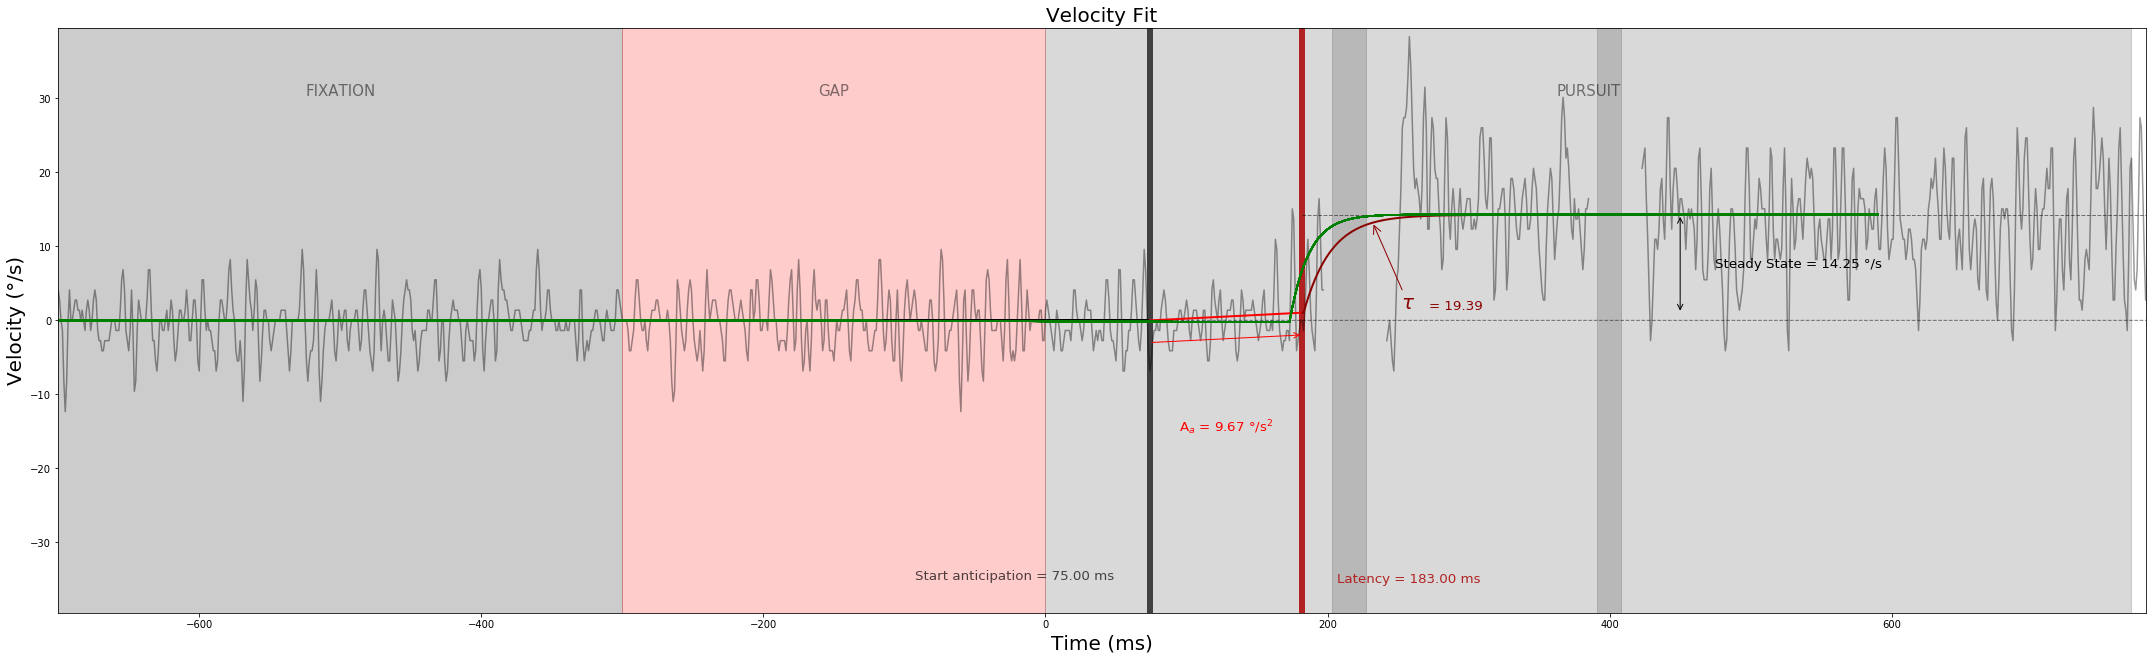

In [6]:
s, t = 0, 11
print(sujets[s])
result_full_data_s0, result_red_data_s0 = moulti_fit(s, t)

CS
[596.26412865 437.84961013 315.27035301 591.76077651 342.29859754
 397.04067089 481.61257295 289.89385756 408.17783269 424.33203717
 304.92803633 251.32133076 441.21034673 544.43845268 604.52419233
 564.50521337 297.64893651 383.62478637 258.4451755  584.91515668
 550.5088736  470.43400952 516.66815201 307.17327699 530.36663488
 355.19720133 565.55339569 544.62764851 572.07943639 321.79220932
 280.95536063 546.32943048 623.72977616 505.8472178  423.90813015
 381.85998867 419.20312763 276.26373474 432.62073612 567.25742966
 551.51723118 605.85739913 481.78950794 270.62993951 512.33052789
 592.92953831 382.80765862 265.21270409 376.89767243 475.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

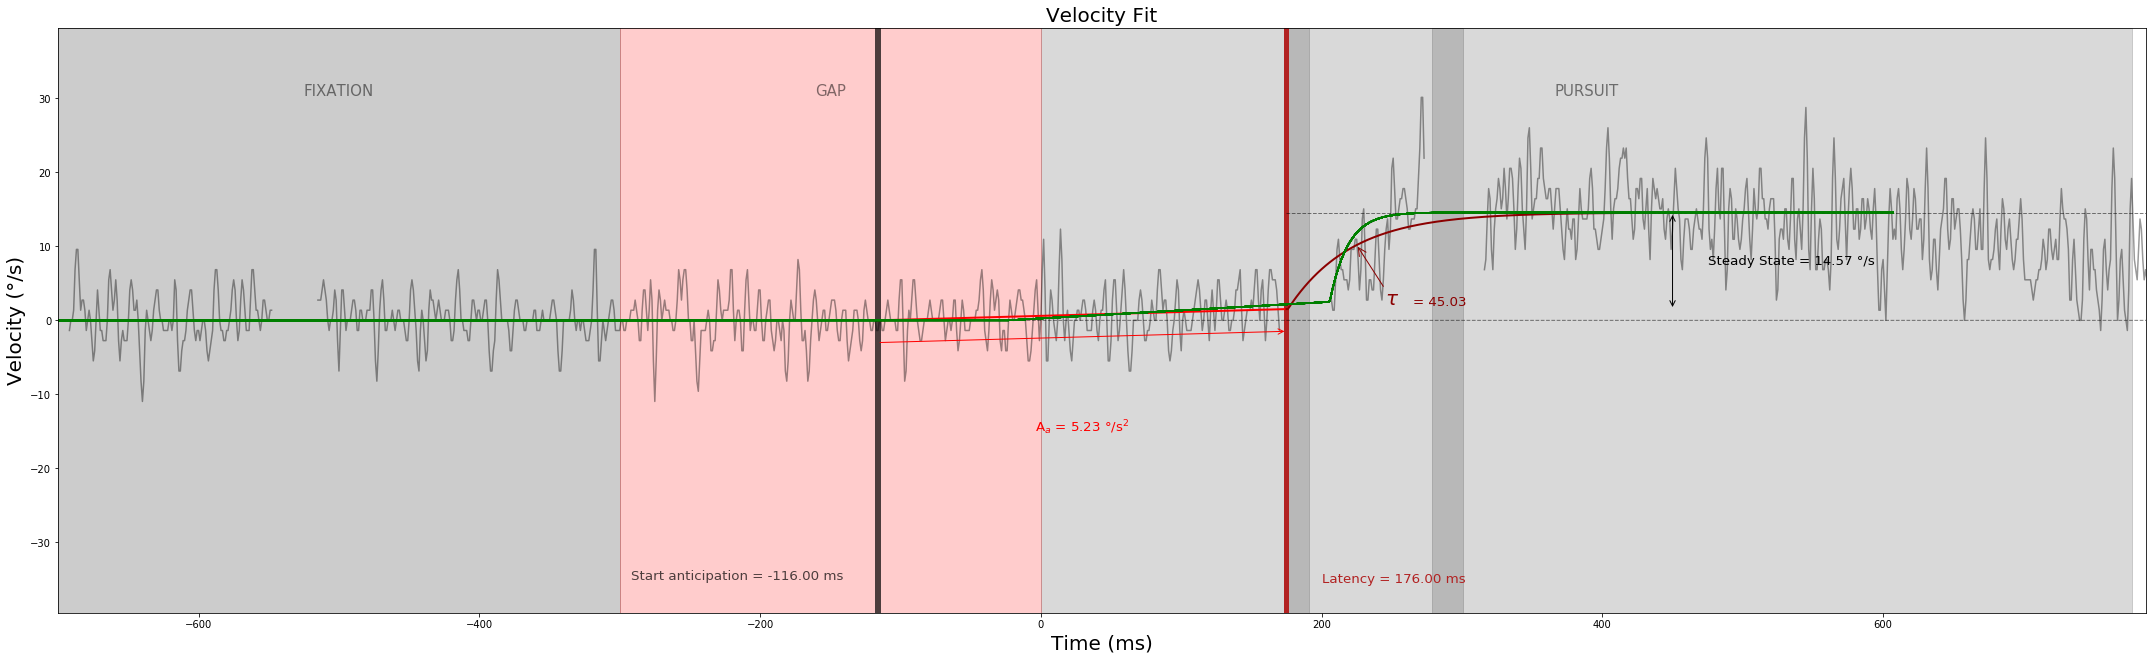

In [7]:
s, t = 2, 11
print(sujets[s])
result_full_data_s2, result_red_data_s2 = moulti_fit(s, t)

DC
[605.26412865 446.84961013 324.27035301 600.76077651 351.29859754
 406.04067089 490.61257295 298.89385756 417.17783269 433.33203717
 313.92803633 260.32133076 450.21034673 553.43845268 613.52419233
 573.50521337 306.64893651 392.62478637 267.4451755  593.91515668
 559.5088736  479.43400952 525.66815201 316.17327699 539.36663488
 364.19720133 574.55339569 553.62764851 581.07943639 330.79220932
 289.95536063 555.32943048 632.72977616 514.8472178  432.90813015
 390.85998867 428.20312763 285.26373474 441.62073612 576.25742966
 560.51723118 614.85739913 490.78950794 279.62993951 521.33052789
 601.92953831 391.80765862 274.21270409 385.89767243 484.00317954]


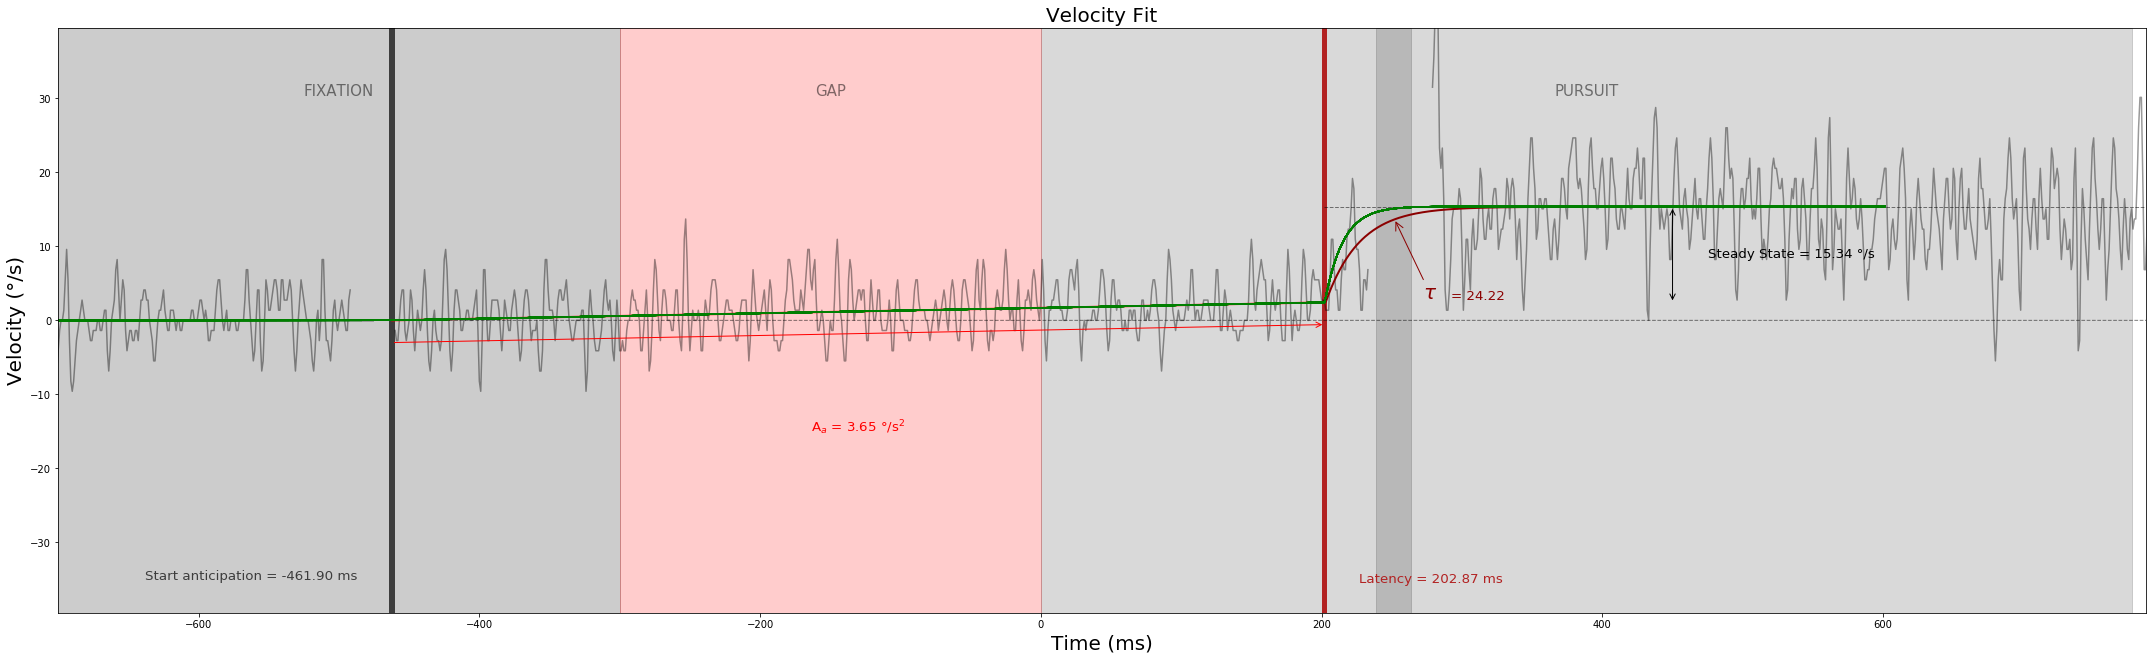

In [8]:
s, t = 3, 11
print(sujets[s])
result_full_data_s3, result_red_data_s3 = moulti_fit(s, t)

IP
[597.26412865 438.84961013 316.27035301 592.76077651 343.29859754
 398.04067089 482.61257295 290.89385756 409.17783269 425.33203717
 305.92803633 252.32133076 442.21034673 545.43845268 605.52419233
 565.50521337 298.64893651 384.62478637 259.4451755  585.91515668
 551.5088736  471.43400952 517.66815201 308.17327699 531.36663488
 356.19720133 566.55339569 545.62764851 573.07943639 322.79220932
 281.95536063 547.32943048 624.72977616 506.8472178  424.90813015
 382.85998867 420.20312763 277.26373474 433.62073612 568.25742966
 552.51723118 606.85739913 482.78950794 271.62993951 513.33052789
 593.92953831 383.80765862 266.21270409 377.89767243 476.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

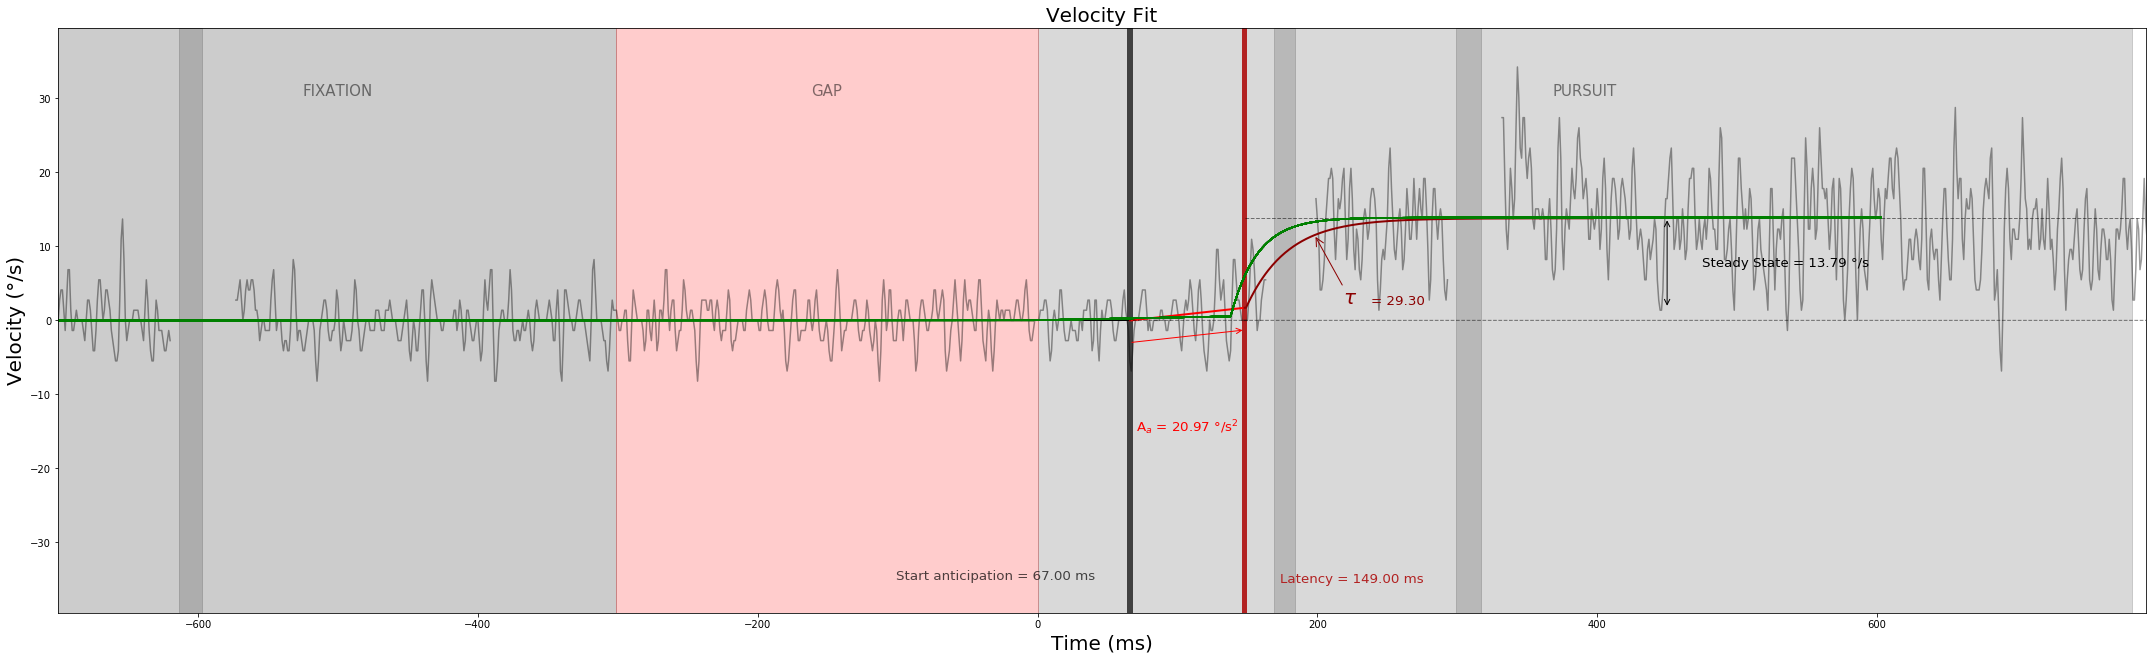

In [9]:
s, t = 5, 11
print(sujets[s])
result_full_data_s5, result_red_data_s5 = moulti_fit(s, t)

# Bad

YK


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


[762.26412865 603.84961013 481.27035301 757.76077651 508.29859754
 563.04067089 647.61257295 455.89385756 574.17783269 590.33203717
 470.92803633 417.32133076 607.21034673 710.43845268 770.52419233
 730.50521337 463.64893651 549.62478637 424.4451755  750.91515668
 716.5088736  636.43400952 682.66815201 473.17327699 696.36663488
 521.19720133 731.55339569 710.62764851 738.07943639 487.79220932
 446.95536063 712.32943048 789.72977616 671.8472178  589.90813015
 547.85998867 585.20312763 442.26373474 598.62073612 733.25742966
 717.51723118 771.85739913 647.78950794 436.62993951 678.33052789
 758.92953831 548.80765862 431.21270409 542.89767243 641.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

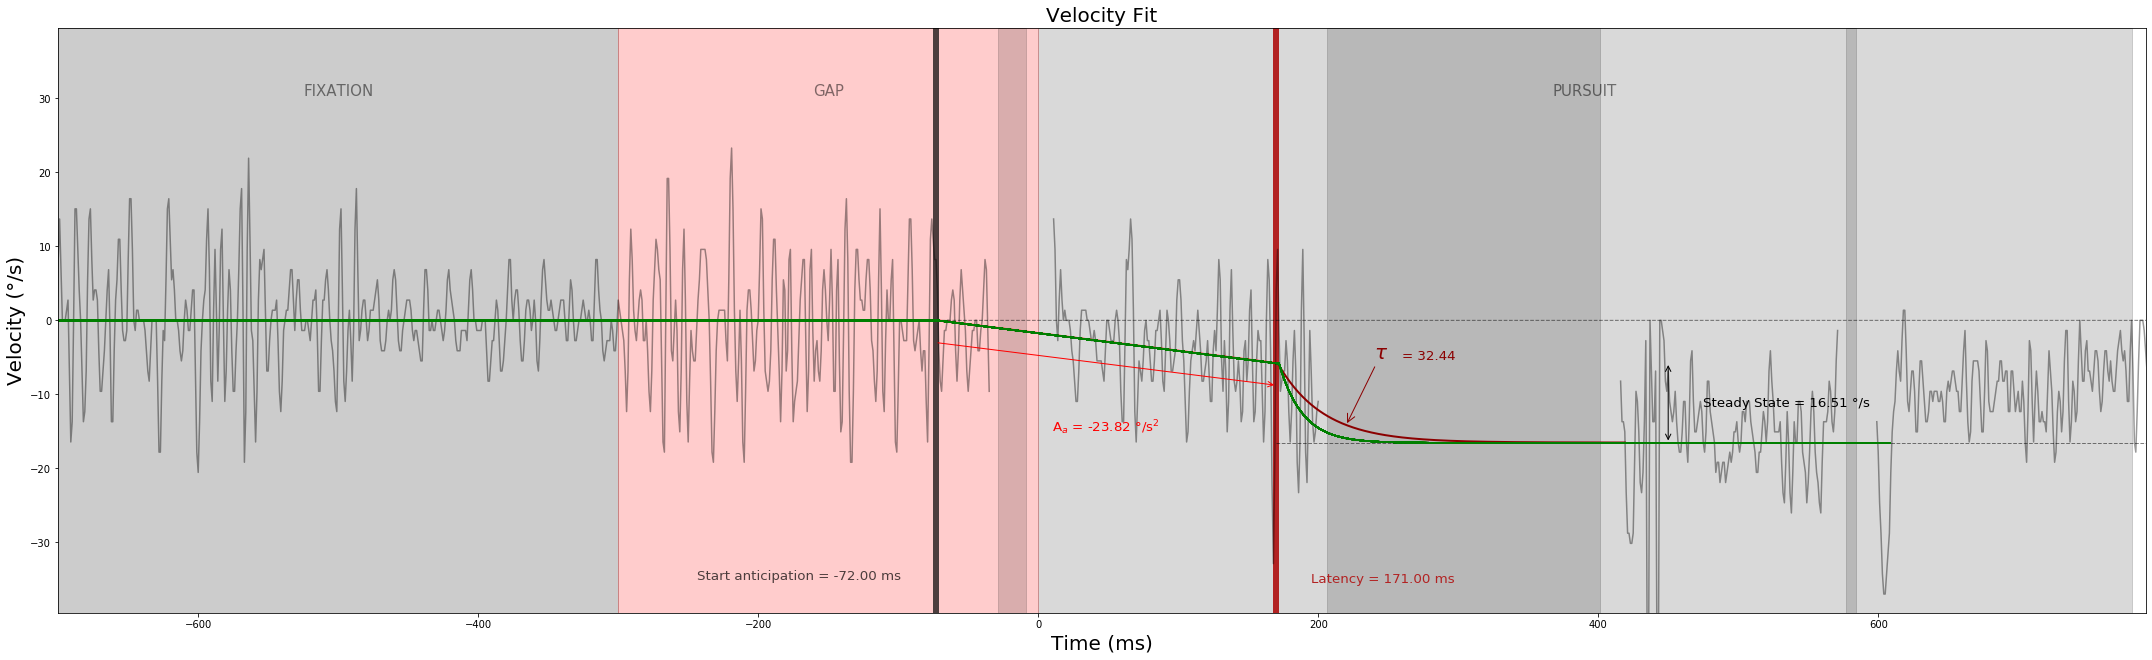

In [10]:
s, t = 11, 58
print(sujets[s])
result_full_data_s11_58, result_red_data_s11_58 = moulti_fit(s, t)

YK
[724.26412865 565.84961013 443.27035301 719.76077651 470.29859754
 525.04067089 609.61257295 417.89385756 536.17783269 552.33203717
 432.92803633 379.32133076 569.21034673 672.43845268 732.52419233
 692.50521337 425.64893651 511.62478637 386.4451755  712.91515668
 678.5088736  598.43400952 644.66815201 435.17327699 658.36663488
 483.19720133 693.55339569 672.62764851 700.07943639 449.79220932
 408.95536063 674.32943048 751.72977616 633.8472178  551.90813015
 509.85998867 547.20312763 404.26373474 560.62073612 695.25742966
 679.51723118 733.85739913 609.78950794 398.62993951 640.33052789
 720.92953831 510.80765862 393.21270409 504.89767243 603.00317954]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/lo

/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/lo

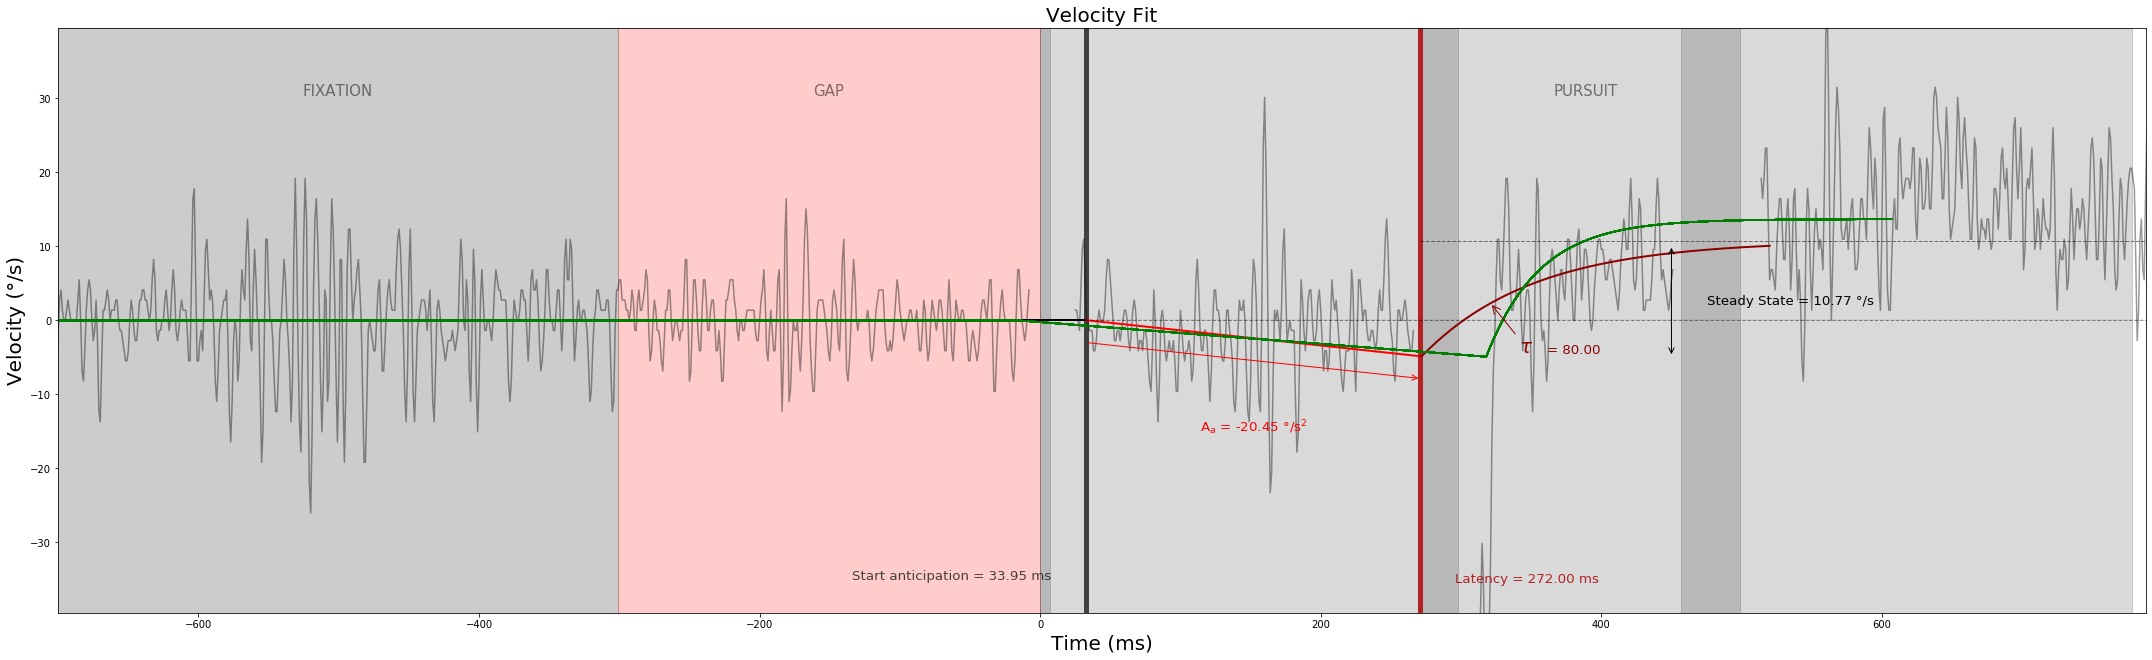

In [11]:
s, t = 11, 82
print(sujets[s])
result_full_data_s11_82, result_red_data_s11_82 = moulti_fit(s, t)

YK
[767.26412865 608.84961013 486.27035301 762.76077651 513.29859754
 568.04067089 652.61257295 460.89385756 579.17783269 595.33203717
 475.92803633 422.32133076 612.21034673 715.43845268 775.52419233
 735.50521337 468.64893651 554.62478637 429.4451755  755.91515668
 721.5088736  641.43400952 687.66815201 478.17327699 701.36663488
 526.19720133 736.55339569 715.62764851 743.07943639 492.79220932
 451.95536063 717.32943048 794.72977616 676.8472178  594.90813015
 552.85998867 590.20312763 447.26373474 603.62073612 738.25742966
 722.51723118 776.85739913 652.78950794 441.62993951 683.33052789
 763.92953831 553.80765862 436.21270409 547.89767243 646.00317954]


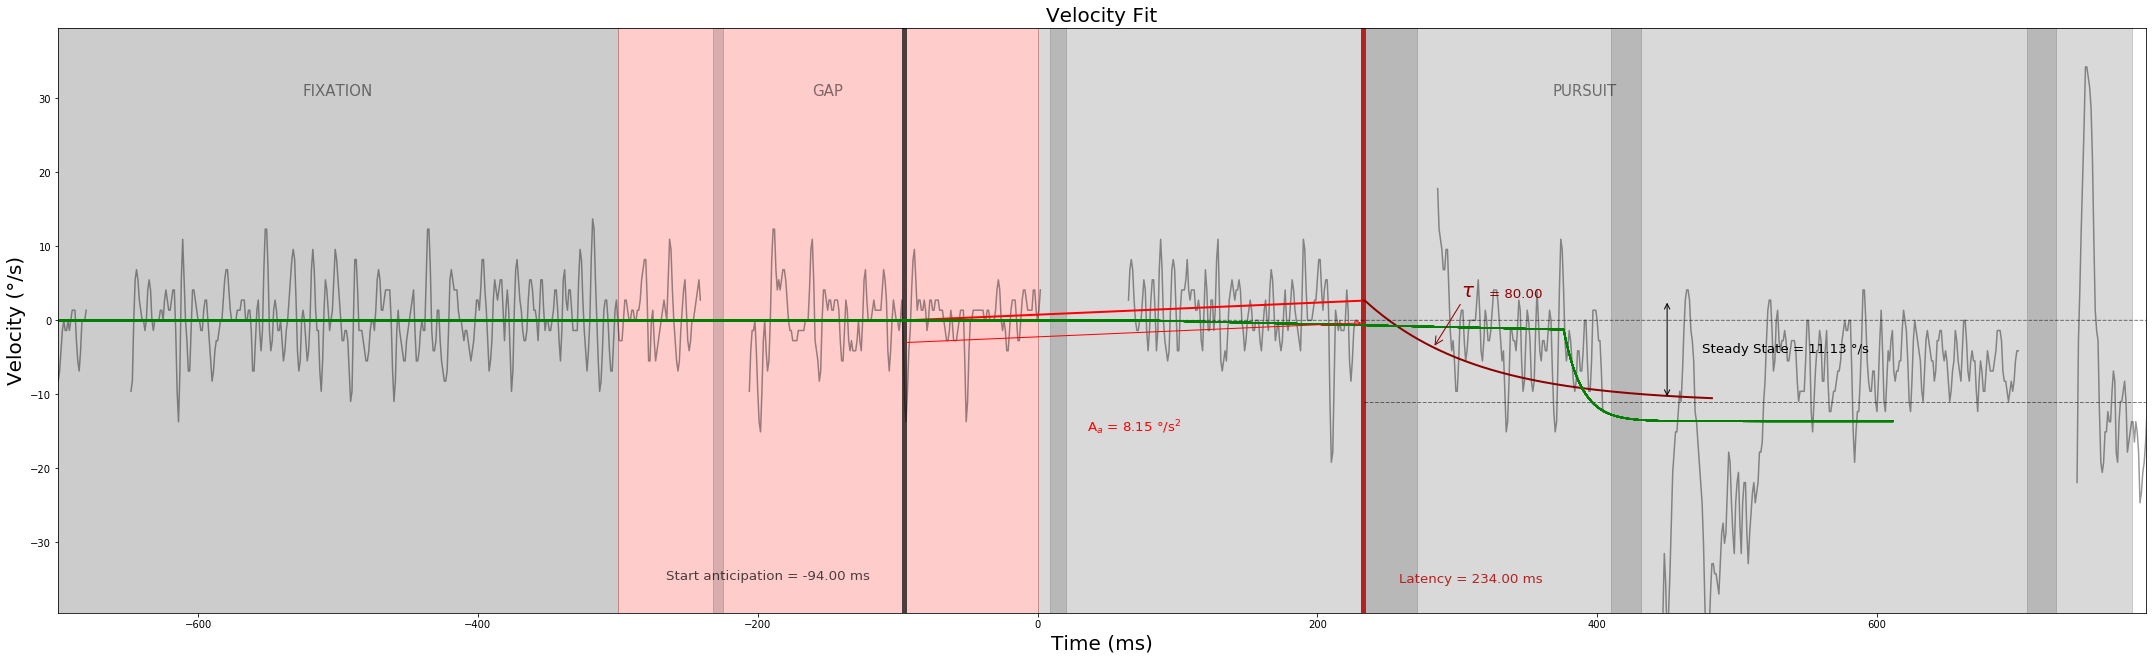

In [12]:
s, t = 11, 190
print(sujets[s])
result_full_data_s11_190, result_red_data_s11_190 = moulti_fit(s, t)

YK
[888.26412865 729.84961013 607.27035301 883.76077651 634.29859754
 689.04067089 773.61257295 581.89385756 700.17783269 716.33203717
 596.92803633 543.32133076 733.21034673 836.43845268 896.52419233
 856.50521337 589.64893651 675.62478637 550.4451755  876.91515668
 842.5088736  762.43400952 808.66815201 599.17327699 822.36663488
 647.19720133 857.55339569 836.62764851 864.07943639 613.79220932
 572.95536063 838.32943048 915.72977616 797.8472178  715.90813015
 673.85998867 711.20312763 568.26373474 724.62073612 859.25742966
 843.51723118 897.85739913 773.78950794 562.62993951 804.33052789
 884.92953831 674.80765862 557.21270409 668.89767243 767.00317954]


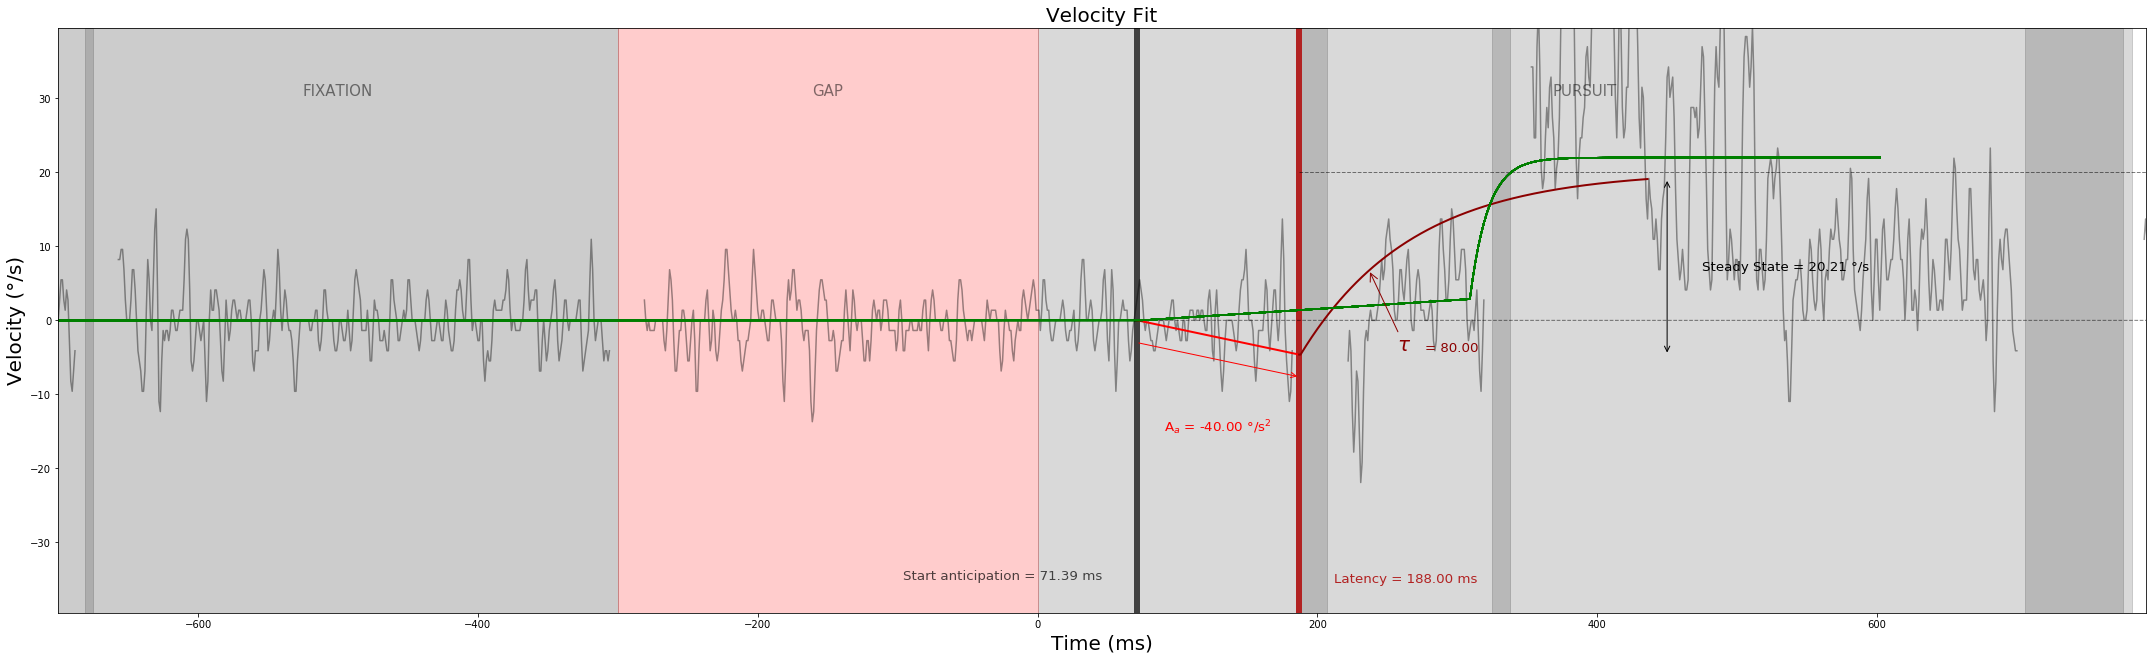

In [13]:
s, t = 11, 191
print(sujets[s])
result_full_data_s11_191, result_red_data_s11_191 = moulti_fit(s, t)

# Hist

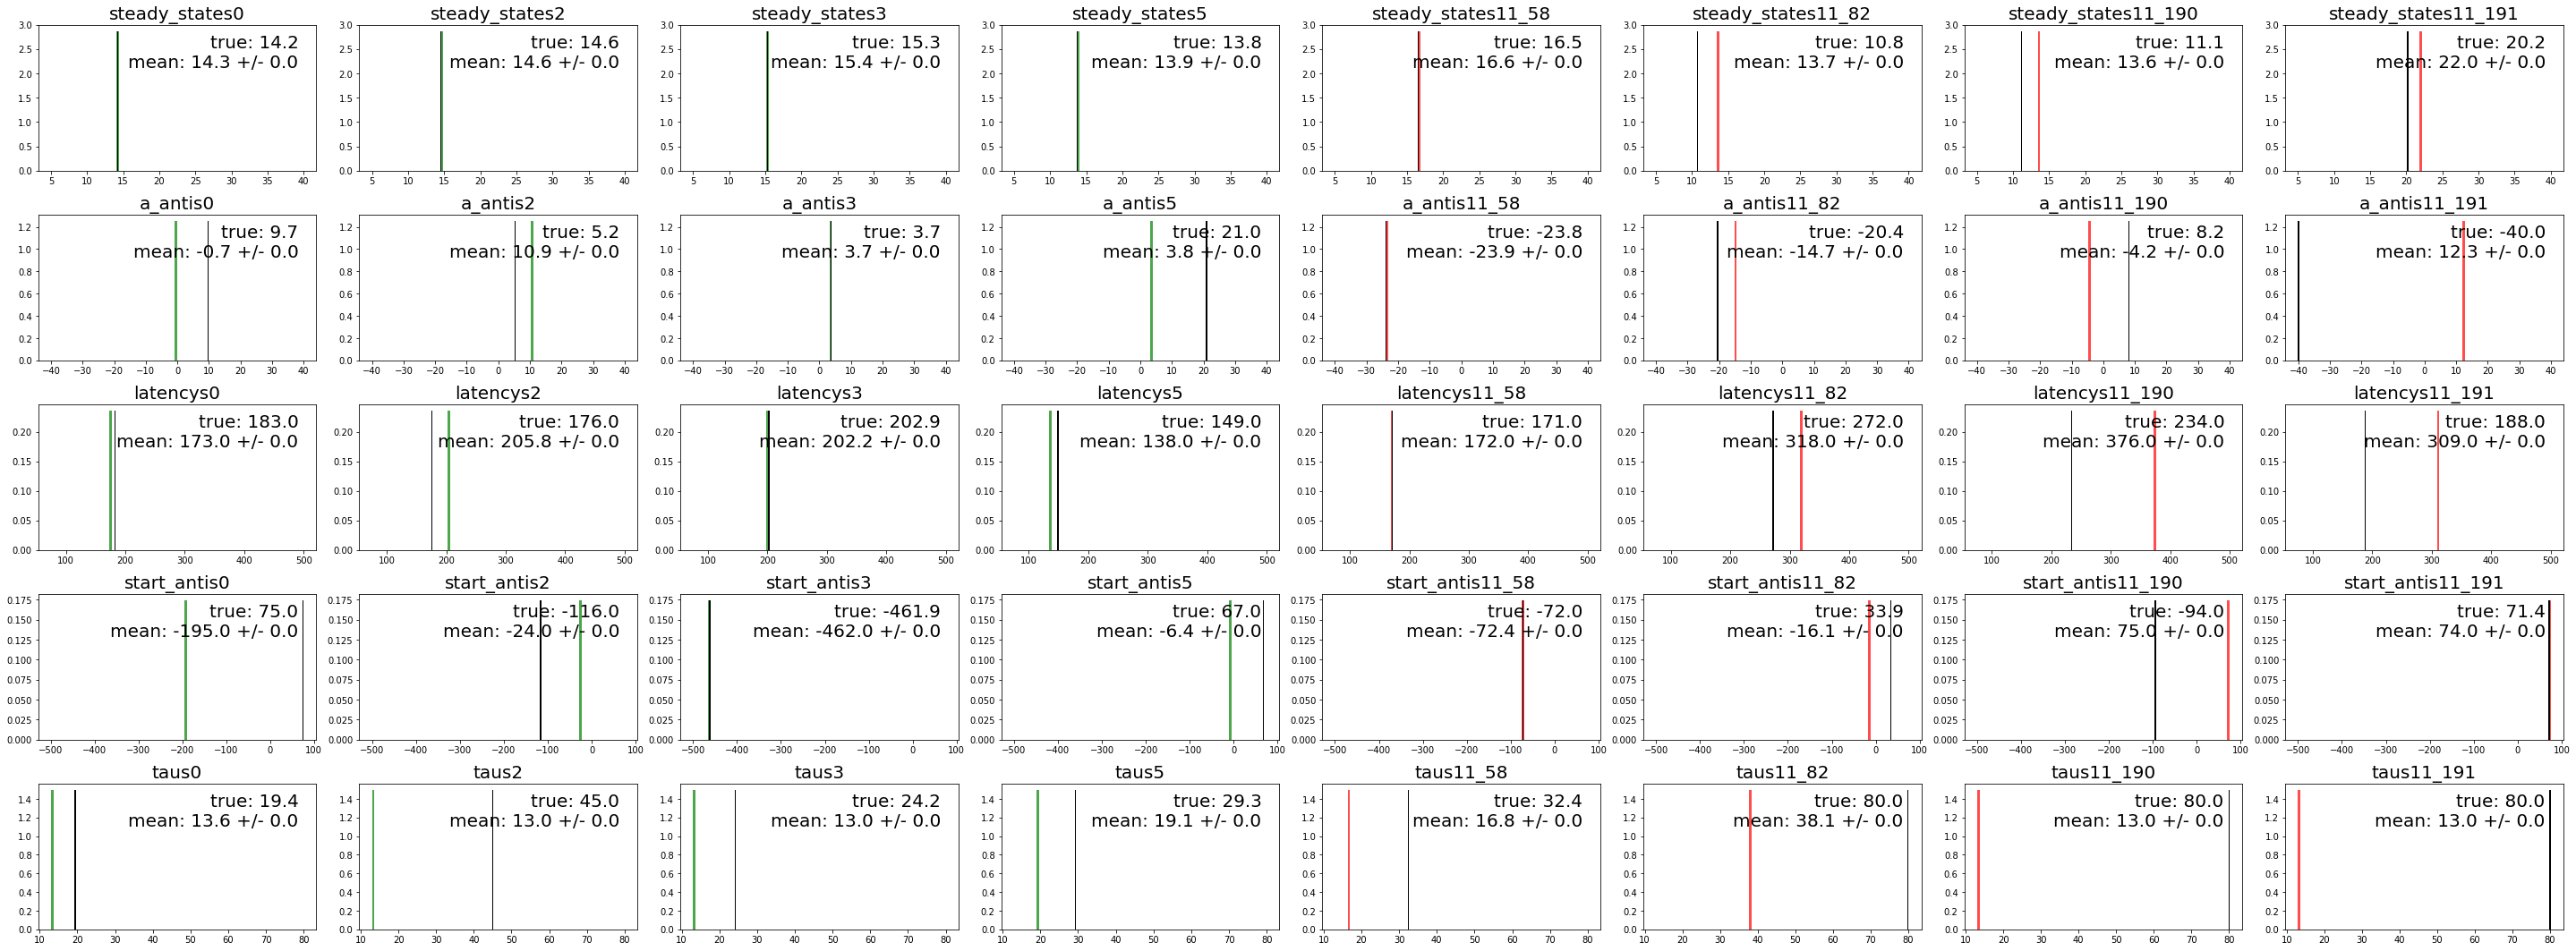

In [14]:
histoto([result_full_data_s0, result_full_data_s2, result_full_data_s3, result_full_data_s5,
         result_full_data_s11_58, result_full_data_s11_82, result_full_data_s11_190, result_full_data_s11_191],
        [result_red_data_s0, result_red_data_s2, result_red_data_s3, result_red_data_s5,
         result_red_data_s11_58, result_red_data_s11_82, result_red_data_s11_190,result_red_data_s11_191],
        ['s0', 's2', 's3', 's5', 's11_58', 's11_82', 's11_190', 's11_191'],
        [ 'g',  'g',  'g',  'g',      'r',      'r',       'r',       'r'], bins=100)